In [58]:
import IPython, nussl, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math,time,vamp
import os
from IPython.display import Audio, display
from scipy.fftpack import fft, ifft
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
import itertools


In [89]:
def createTestAndTrain(path_to_csv, percent_train=80, num_genres=10):
    """
    Partition the dataset into testing and training data
    
    Inputs: 
    
    path_to_csv: given path to csv
    percent_train: percentage of dataset that is used to train the model
    num_genres: the number of genres used in the dataset
    
    Outputs:
    
    (train, genres_train) = a tuple of the training data and the training labels
    (test, genres_test) = a tuple of the testing data and the testing labels
    """
    
    # get csv data
    csv = np.genfromtxt(path_to_csv, dtype='string', delimiter=',', skip_header=1)
    genre_subsets = np.split(csv, num_genres)
    for i, value in enumerate(genre_subsets):
        np.random.shuffle(genre_subsets[i])
    csv = np.concatenate(genre_subsets)
    
    # separate into vectors and labels
    labels = csv[:,-1]
    feature_vectors = csv[:,:-1].astype(float)
    feature_vectors = normalize(feature_vectors, axis=0)
    
    train = feature_vectors[np.where(np.arange(feature_vectors.shape[0]) % 100 < percent_train)]
    test = feature_vectors[np.where(np.arange(feature_vectors.shape[0]) % 100 >= percent_train)]
    genres_train = labels[np.where(np.arange(labels.shape[0]) % 100 < percent_train)]
    genres_test = labels[np.where(np.arange(labels.shape[0]) % 100 >= percent_train)]
    
    return (train, genres_train), (test, genres_test)

def prediction_accuracy(predictions, labels):
    '''
    Calculates the accuracy of a model's predictions
    
    Inputs:
    
    predictions: 1D array of predicted classifications of test data
    labels: 1D array of  actual classifications
    
    Outputs:
    
    accuracy: The prediction accuracy
    '''
    count = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            count += 1
    accuracy = float(count)/len(genres_test)
    return accuracy

In [53]:
def trainGaussianNB(path_to_csv):
    """
    Trains a Gaussian Naive Bayes model and returns its predictions
    
    Inputs: 
    
    path_to_csv: given path to dataset csv
    
    Outputs:
    
    predictions: 1D array of predicted classifications of test data
    genres_test: 1D array of  actual classifications 
    """
    # partition out training and testing sets
    training, testing = createTestAndTrain(path_to_csv)
    train = training[0]
    genres_train = training[1]
    test = testing[0]
    genres_test = testing[1]
    
    # train
    gnb = GaussianNB()
    gnb.fit(train, genres_train) 
    
    # output prediction accuracy
    predictions = gnb.predict(test)
    return predictions, genres_test

In [54]:
def trainNN(path_to_csv, num_neighbors = 4):
    """
    Trains a k-Nearest Neighbors model and returns its predictions
    
    Inputs: 
    
    path_to_csv: given path to dataset csv
    num_neighbors: k
    
    Outputs:
    
    predictions: 1D array of predicted classifications of test data
    genres_test: 1D array of  actual classifications 
    """
    # partition out training and testing sets
    training, testing = createTestAndTrain(path_to_csv)
    train = training[0]
    genres_train = training[1]
    test = testing[0]
    genres_test = testing[1]
    
    # train
    nn = KNeighborsClassifier(n_neighbors=num_neighbors)
    nn.fit(train, genres_train) 
    
    # output prediction accuracy
    predictions = nn.predict(test)
    
    return predictions, genres_test

In [91]:
def trainSVC(path_to_csv):
    """
    Trains a SVC Model and returns its predictions
    
    Inputs: 
    
    path_to_csv: given path to dataset csv
    
    Outputs:
    
    predictions: 1D array of predicted classifications of test data
    genres_test: 1D array of  actual classifications    
    """
    # partition out training and testing sets
    training, testing = createTestAndTrain(path_to_csv)
    train = training[0]
    genres_train = training[1]
    test = testing[0]
    genres_test = testing[1]
    
    # train
    clf = SVC()
    clf.fit(train, genres_train) 

    # output prediction accuracy
    predictions = clf.predict(test)
    
    return predictions, genres_test

In [92]:
def getAveragePredictionAccuracy(modelFunction, csv_file, num_times):
    '''
    Finds the average prediction of a model on a dataset over an inputted number of times
    '''
    prediction_scores = np.array([])
    for i in np.arange(num_times):
        predictions, labels = modelFunction(csv_file)
        prediction_scores = np.append(prediction_scores, prediction_accuracy(predictions, labels))
    
    mean_score = np.mean(prediction_scores)
    return mean_score

In [43]:
datasets = ['features/control.csv', 'features/hpss_harmonic.csv', 'features/hpss_percussive.csv', 'features/repet_foreground.csv', 'features/repet_background.csv', 'features/repet_f_b_combo.csv', 'features/repet_avg.csv', 'features/hpss_avg.csv', 'features/hpss_h_p_combo.csv']
modelFunctions = [trainNN, trainGaussianNB, trainSVC]
results = {}
for dataset in datasets:
    results[dataset] = []
    for index, model in enumerate(modelFunctions):
        results[dataset].append(getAveragePredictionAccuracy(model, dataset, 100))

with open('results.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Dataset', 'Nearest Neighbor', 'Gaussian', 'SVC'])
    for key, value in results.items():
       writer.writerow([key] + value)        


In [80]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [90]:
def get_confusion_matrix(dataset, model, display = True):
    '''
    Returns and prints the confusion matrix
    '''
    predictions, labels = model(dataset)
    genres = np.unique(labels)
    cm = sklearn.metrics.confusion_matrix(labels, predictions, genres)
    if display:
        plot_confusion_matrix(cm, genres, title = "Confusion Matrix for " + dataset)
        plt.show
    return cm

Confusion matrix, without normalization
[[ 6  1  0  1  1  2  5  2  0  2]
 [ 0 16  0  0  0  1  2  0  0  1]
 [ 1  0  4  4  0  4  2  1  2  2]
 [ 0  0  1 13  2  0  1  3  0  0]
 [ 1  0  3  4  3  0  0  6  2  1]
 [ 0  3  4  0  0 10  0  2  1  0]
 [ 0  0  0  0  1  0 17  0  1  1]
 [ 1  1  2  1  8  0  0  7  0  0]
 [ 3  0  1  1  4  3  0  0  8  0]
 [ 1  1  3  6  0  2  2  1  0  4]]


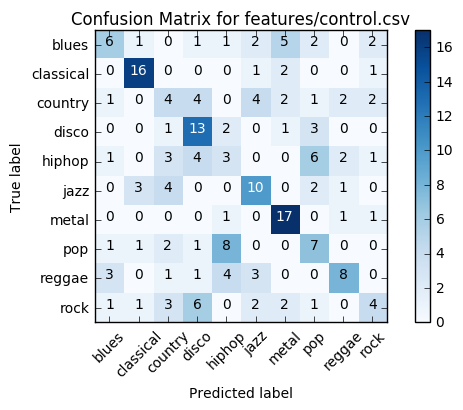

Confusion matrix, without normalization
[[ 3  0  0  5  0  4  3  1  4  0]
 [ 0 13  3  2  0  1  0  0  1  0]
 [ 1  1  6  2  0  4  1  0  3  2]
 [ 0  0  1 10  0  0  1  6  2  0]
 [ 1  0  1  2  2  1  2  6  4  1]
 [ 2  3  3  3  1  6  0  1  1  0]
 [ 0  1  0  2  0  0 16  0  0  1]
 [ 0  0  3  6  0  2  1  5  2  1]
 [ 0  0  2  1  2  2  0  3  9  1]
 [ 0  0  2  4  0  0  2  5  5  2]]


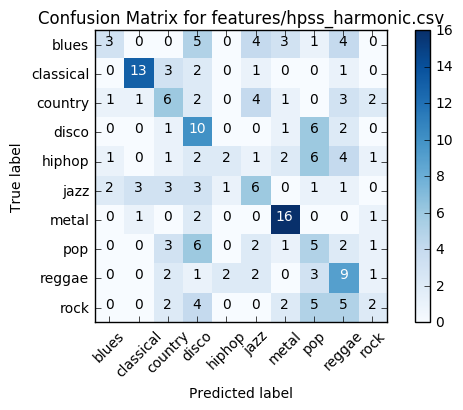

Confusion matrix, without normalization
[[ 4  1  0  3  2  5  0  1  4  0]
 [ 0 15  3  0  0  2  0  0  0  0]
 [ 0  1  3  5  1  3  5  1  1  0]
 [ 0  0  0 14  2  0  1  1  2  0]
 [ 2  0  1  3  8  0  0  3  1  2]
 [ 1  2  0  0  0 13  0  1  1  2]
 [ 0  1  0  0  0  0 18  0  0  1]
 [ 0  0  3  5  3  0  0  4  2  3]
 [ 2  0  4  2  4  1  0  3  3  1]
 [ 0  3  2  4  0  2  6  0  1  2]]


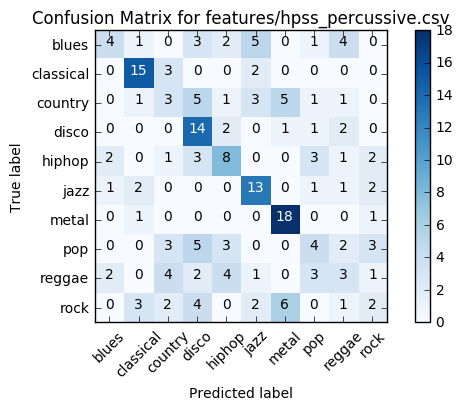

Confusion matrix, without normalization
[[ 3  0  1  2  1  7  2  3  0  1]
 [ 0 16  1  0  0  1  0  0  0  2]
 [ 2  1  3  4  0  2  2  0  4  2]
 [ 0  0  1 10  1  0  4  2  2  0]
 [ 0  0  0  2 10  1  5  2  0  0]
 [ 1  4  0  1  0  9  0  0  1  4]
 [ 0  0  0  0  1  0 18  1  0  0]
 [ 1  1  1  4  1  1  0  9  2  0]
 [ 1  0  3  1  6  1  0  1  7  0]
 [ 0  2  1  3  2  4  2  2  2  2]]


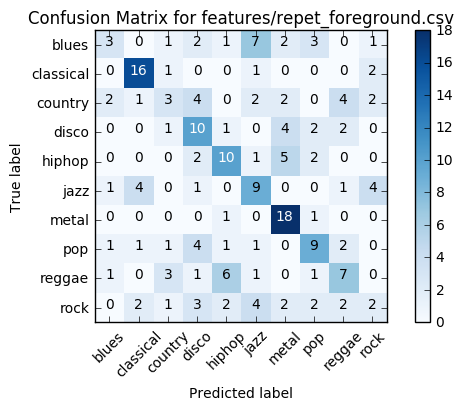

Confusion matrix, without normalization
[[ 1  2  4  5  0  7  0  1  0  0]
 [ 0 18  0  0  0  0  1  0  1  0]
 [ 1  1  9  5  0  2  1  0  0  1]
 [ 1  1  1  8  1  0  5  2  1  0]
 [ 1  0  0  2  8  0  1  4  4  0]
 [ 1  3  2  2  0 11  0  0  0  1]
 [ 0  0  1  1  1  0 17  0  0  0]
 [ 0  1  5  4  4  0  0  6  0  0]
 [ 0  0  3  0  2  2  0  1 12  0]
 [ 0  0  3  2  1  1  7  0  3  3]]


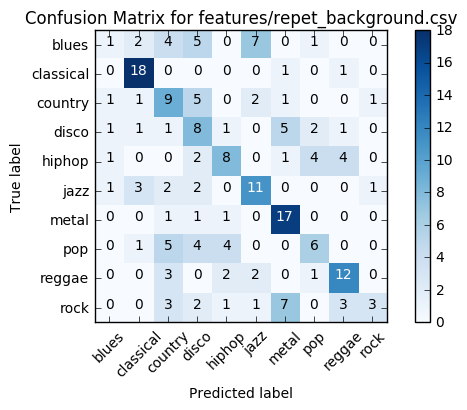

Confusion matrix, without normalization
[[ 1  0  5  5  0  6  2  1  0  0]
 [ 0 15  0  0  0  3  0  0  0  2]
 [ 4  0  9  2  0  2  2  0  1  0]
 [ 0  1  3 10  2  0  1  1  1  1]
 [ 0  0  1  6  8  0  1  0  4  0]
 [ 1  2  1  1  0 13  1  0  0  1]
 [ 0  0  1  2  2  0 14  0  0  1]
 [ 2  0  1  0  7  0  0  9  0  1]
 [ 1  0  3  0  6  2  0  0  8  0]
 [ 1  0  2  3  1  1  6  0  0  6]]


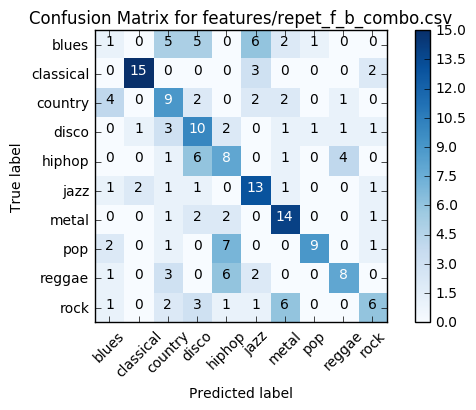

Confusion matrix, without normalization
[[ 3  1  2  4  1  3  1  3  2  0]
 [ 0 18  0  1  0  0  1  0  0  0]
 [ 2  0  6  5  0  4  2  0  1  0]
 [ 0  0  1 10  3  0  4  0  2  0]
 [ 0  0  1  2  4  1  0  7  4  1]
 [ 1  0  2  0  0 16  0  0  0  1]
 [ 0  0  1  2  1  0 16  0  0  0]
 [ 1  0  2  2  8  2  0  5  0  0]
 [ 2  0  5  2  3  3  0  1  3  1]
 [ 0  0  2  6  1  2  5  1  0  3]]


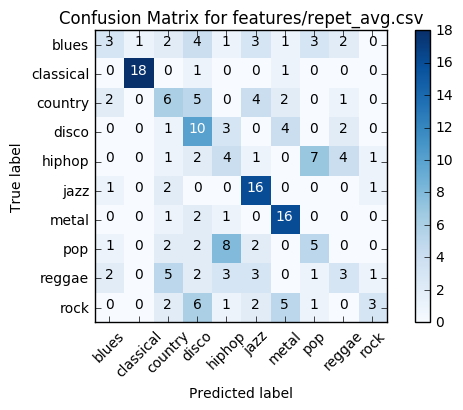

Confusion matrix, without normalization
[[ 1  3  0  4  0  6  3  2  0  1]
 [ 0 13  3  0  0  2  0  0  0  2]
 [ 1  0  2  4  0  7  2  2  2  0]
 [ 0  0  0  8  2  0  1  7  1  1]
 [ 1  0  0  4  8  0  1  1  4  1]
 [ 0  2  1  1  0 11  0  1  1  3]
 [ 0  1  0  0  1  0 18  0  0  0]
 [ 0  0  1  3  4  0  0 10  2  0]
 [ 2  0  6  2  1  0  0  4  4  1]
 [ 0  0  3  2  1  2  5  3  1  3]]


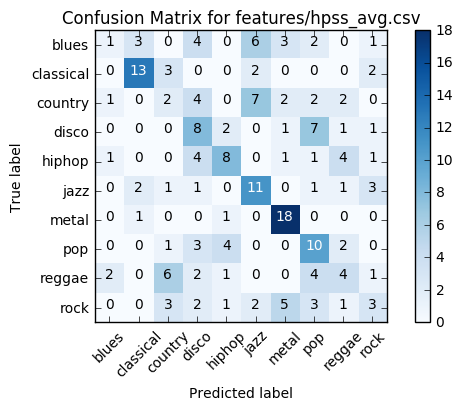

Confusion matrix, without normalization
[[ 1  3  0  6  0  4  2  3  1  0]
 [ 0 16  0  0  0  2  0  0  0  2]
 [ 2  0  6  2  1  2  2  1  0  4]
 [ 0  0  2 11  0  0  5  1  1  0]
 [ 3  0  2  6  4  0  0  2  2  1]
 [ 0  3  3  0  0 11  0  0  1  2]
 [ 0  1  0  0  2  0 15  1  0  1]
 [ 0  0  2  1  2  1  0 10  4  0]
 [ 2  0  3  3  2  2  0  0  8  0]
 [ 1  1  3  4  0  2  2  3  0  4]]


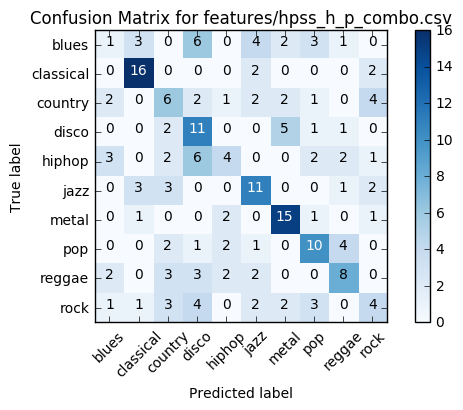

In [86]:
datasets = ['features/control.csv', 'features/hpss_harmonic.csv', 'features/hpss_percussive.csv', 'features/repet_foreground.csv', 'features/repet_background.csv', 'features/repet_f_b_combo.csv', 'features/repet_avg.csv', 'features/hpss_avg.csv', 'features/hpss_h_p_combo.csv']
for dataset in datasets:
    cm = get_confusion_matrix(dataset, trainGaussianNB)